In [43]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

nltk.download('punkt')

import torch
import torchtext
from torchtext import data
import os
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# Please change the following path to your current directory in order to run the code properly
# os.chdir("/content/drive/MyDrive/ECE1786/Project")
%cd /content/drive/MyDrive/Colab Notebooks/ECE1786/Project

/content/drive/MyDrive/Colab Notebooks/ECE1786/Project


In [45]:
ls

baselines.ipynb  BERT_GRU.ipynb  CNN.pt  data_preprocessing.ipynb  GPT2.pt
BERT_base.ipynb  CNN.ipynb       data/   GPT2.ipynb


# Data Preprocessing

## Load the dataset

### Dataset 1: Hate Speech and Offensive Language Dataset

In [46]:
# load dataset
dataset1 = pd.read_csv('data/dataset1.csv')
# https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
# 0 - hate speech 1 - offensive language 2 - neither

dataset1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [47]:
# only keep the text and label column
dataset1 = dataset1[['tweet','class']]
dataset1

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,"you've gone and broke the wrong heart baby, an...",2
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


In [48]:
dataset1[dataset1['class']==0]

,tweet,class
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...",0
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...",0
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b...",0
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...",0
202,"""@NoChillPaz: ""At least I'm not a nigger"" http...",0
...,...,...
24576,this guy is the biggest faggot omfg,0
24685,which one of these names is more offensive kik...,0
24751,you a pussy ass nigga and I know it nigga.,0
24776,you're all niggers,0


In [49]:
dataset1[dataset1['class']==1]

,tweet,class
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",1
...,...,...
24774,you really care bout dis bitch. my dick all in...,1
24775,"you worried bout other bitches, you need me for?",1
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24780,young buck wanna eat!!.. dat nigguh like I ain...,1


In [50]:
dataset1[dataset1['class']==2]

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
40,""" momma said no pussy cats inside my doghouse """,2
63,"""@Addicted2Guys: -SimplyAddictedToGuys http://...",2
66,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...",2
67,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...",2
...,...,...
24736,yaya ho.. cute avi tho RT @ViVaLa_Ari I had no...,2
24737,yea so about @N_tel 's new friend.. all my fri...,2
24767,"you know what they say, the early bird gets th...",2
24779,"you've gone and broke the wrong heart baby, an...",2


In [51]:
# check the number of rows and columns
dataset1.shape

(24783, 2)

In [52]:
# check if there is any null item
dataset1.isnull().sum()

tweet    0
class    0
dtype: int64

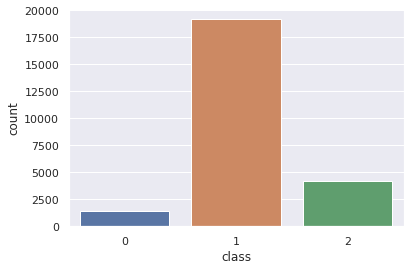

In [53]:
ax = sns.countplot(x="class", data=dataset1)

### Dataset 2: Multimodal Hate Speech Dataset

In [54]:
# add more hate speeches

dataset2 = pd.read_json("data/MMHS150K_GT.json",orient='index')
# https://www.kaggle.com/datasets/victorcallejasf/multimodal-hate-speech

In [55]:
dataset2 = dataset2.reset_index()[['tweet_text', 'labels_str']]
dataset2.head()

,tweet_text,labels_str
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[Religion, Racist, Homophobe]"
1,My horses are retarded https://t.co/HYhqc6d5WN,"[OtherHate, OtherHate, OtherHate]"
2,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[NotHate, NotHate, NotHate]"
3,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[Racist, NotHate, NotHate]"
4,“EVERYbody calling you Nigger now!” https://t....,"[Racist, NotHate, Racist]"


In [56]:
def find_hate(labels):
    if 'NotHate' in labels: return 'NotHate'
    return 'Hate'

In [57]:
dataset2['label'] = dataset2['labels_str'].apply(find_hate)
dataset2_hate = dataset2[dataset2['label']=='Hate']
dataset2_hate

,tweet_text,labels_str,label
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[Religion, Racist, Homophobe]",Hate
1,My horses are retarded https://t.co/HYhqc6d5WN,"[OtherHate, OtherHate, OtherHate]",Hate
6,@WhiteHouse @realDonaldTrump Fuck ice. White s...,"[OtherHate, Racist, Racist]",Hate
14,bf: move your bighead 😅😂 gf: NIGGA WHAT?? THA...,"[Sexist, Sexist, Racist]",Hate
31,@machinegunkelly and @lilxanfuhyobih are the J...,"[Homophobe, Racist, Racist]",Hate
...,...,...,...
149768,@BreitbartNews Sarah Silverman has gone total ...,"[OtherHate, OtherHate, OtherHate]",Hate
149769,faggot in need of attention https://t.co/sRBAa...,"[OtherHate, Homophobe, OtherHate]",Hate
149773,Full Video: https://t.co/v6EvkRCQQw Curvaceous...,"[Homophobe, Sexist, Sexist]",Hate
149789,Arab Spring's Legacy: Islamist Gang Terror #...,"[OtherHate, Racist, Religion]",Hate


In [58]:
dataset2_hate['class']=0
dataset2 = dataset2_hate.rename({'tweet_text': 'tweet'}, axis='columns')[['tweet','class']]
dataset2

,tweet,class
0,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,0
1,My horses are retarded https://t.co/HYhqc6d5WN,0
6,@WhiteHouse @realDonaldTrump Fuck ice. White s...,0
14,bf: move your bighead 😅😂 gf: NIGGA WHAT?? THA...,0
31,@machinegunkelly and @lilxanfuhyobih are the J...,0
...,...,...
149768,@BreitbartNews Sarah Silverman has gone total ...,0
149769,faggot in need of attention https://t.co/sRBAa...,0
149773,Full Video: https://t.co/v6EvkRCQQw Curvaceous...,0
149789,Arab Spring's Legacy: Islamist Gang Terror #...,0


### Dataset 3: Sentiment140 dataset

In [59]:
dataset3 = pd.read_csv('data/dataset3.csv', encoding = 'latin')
# https://www.kaggle.com/datasets/kazanova/sentiment140
# 0 = negative, 2 = neutral, 4 = positive
dataset3.columns = ['Sentiment', 'Id', 'Date', 'Query','User_name', 'Text']

In [60]:
dataset3 = dataset3[['Sentiment', 'Text']]
dataset3

,Sentiment,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...


In [61]:
dataset3_pos = dataset3[dataset3['Sentiment']==4]
dataset3_pos

,Sentiment,Text
799999,4,I LOVE @Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,Being sick can be really cheap when it hurts t...
800003,4,@LovesBrooklyn2 he has that effect on everyone
...,...,...
1599994,4,Just woke up. Having no school is the best fee...
1599995,4,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,Happy 38th Birthday to my boo of alll time!!! ...


In [62]:
dataset3_pos.loc[:,'class']=2
dataset3 = dataset3_pos.rename({'Text': 'tweet'}, axis='columns')[['tweet','class']]
dataset3

,tweet,class
799999,I LOVE @Health4UandPets u guys r the best!!,2
800000,im meeting up with one of my besties tonight! ...,2
800001,"@DaRealSunisaKim Thanks for the Twitter add, S...",2
800002,Being sick can be really cheap when it hurts t...,2
800003,@LovesBrooklyn2 he has that effect on everyone,2
...,...,...
1599994,Just woke up. Having no school is the best fee...,2
1599995,TheWDB.com - Very cool to hear old Walt interv...,2
1599996,Are you ready for your MoJo Makeover? Ask me f...,2
1599997,Happy 38th Birthday to my boo of alll time!!! ...,2


In [63]:
dataset3 = dataset3.sample(frac= 0.02,random_state = 2)
dataset3

,tweet,class
1107080,heading to PA with Cara and Tielyr for Kirra's...,2
1109312,sitting all alone. and want someone to come an...,2
881334,@yeqing_one dont stress! jiayou qingqing!,2
1347321,@Meezp your tweet was just included in The Lon...,2
1255569,@tcarringer Hmmm... Google is the Beast. Not s...,2
...,...,...
1325489,@vimarie I SAW YOU OPENING THE DOOR! i wish i...,2
864072,@Ravels mighty night lovely lady. It was fun p...,2
1555330,@brentkeith I see you running around BB Kings....,2
995600,"@ShropshirePixie there there, here, use my han...",2


### Final Dataset: Combine All Selected Data from Above

In [64]:
dataset = pd.concat([dataset1,dataset2,dataset3]).reset_index(drop=True)
dataset

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
49355,@vimarie I SAW YOU OPENING THE DOOR! i wish i...,2
49356,@Ravels mighty night lovely lady. It was fun p...,2
49357,@brentkeith I see you running around BB Kings....,2
49358,"@ShropshirePixie there there, here, use my han...",2


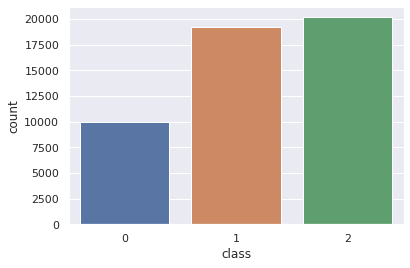

In [65]:
ax = sns.countplot(x="class", data=dataset)

## Data Cleaning

In [66]:
# helper function to convert abbreviated form to original form
def convert_to_original(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [67]:
# text data cleaning
def data_processing(text):
  # lower casing
  text = str(text).lower()

  # remove unicode strings
  text = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', text)

  # remove non-ascii characters
  text = re.sub(r'[^\x00-\x7f]', r'', text)

  # remove @user indicaters
  text = re.sub(r'@\w+', r'', text)

  # remove digits
  text = re.sub(r'\d', r'', text)

  # remove '#' symbols inside strings
  text = re.sub(r'#', r'', text)

  # remove rt tag in html
  text = re.sub(r'rt', r'', text)

  # remove “ampersand” reference in html
  text = re.sub(r'amp|&amp', r'', text)

  # remove urls
  text = re.sub(r'http\S+', r'', text)

  # remove multiple white spaces
  text = re.sub(r'[\s]+', r' ', text)

  # remove multiple break-line with single white space.
  text = re.sub(r'[\n]+', r' ', text)

  # split the text (tokenization)
  text = nltk.word_tokenize(text)

  # convert abbreviated form to original form
  text = convert_to_original(' '.join(text)).split()

  # remove short strings with length=1 and length=2
  text = [word for word in text if not len(word) in [1,2]]

  # remove non-alphanumeric characters
  text = [word for word in text if word.isalpha()]

  return ' '.join(text)

In [68]:
dataset_cleaned = dataset.copy()

In [69]:
dataset_cleaned['tweet'] = dataset_cleaned['tweet'].apply(data_processing)
dataset_cleaned

,tweet,class
0,woman you should not complain about cleaning y...,2
1,boy dats cold tyga dwn bad for cuffin dat hoe ...,1
2,dawg you ever fuck bitch and she sta cry you c...,1
3,she look like tranny,1
4,the shit you hear about might true might faker...,1
...,...,...
49355,saw you opening the door wish was actually the...,2
49356,mighty night lovely lady was fun passing out s...,2
49357,see you running around kings not wait for you ...,2
49358,there there here use hankie freshly laundered ...,2


In [70]:
dataset_cleaned['tweet'].replace('', np.nan, inplace=True)

In [71]:
dataset_cleaned.isnull().sum()

tweet    90
class     0
dtype: int64

In [72]:
dataset_cleaned.dropna(subset=['tweet'], inplace=True)

In [73]:
dataset_cleaned.isnull().sum()

tweet    0
class    0
dtype: int64

In [74]:
# example before and after data cleaning
print(dataset['tweet'][0])
print(dataset_cleaned['tweet'][0])

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
woman you should not complain about cleaning your house man you should always take the trash out


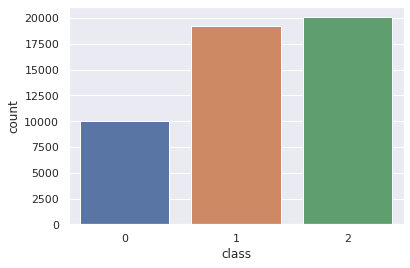

In [75]:
# Before balancing data
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dataset_cleaned)

In [76]:
# dataset value counts
dataset_cleaned['class'].value_counts(normalize = True)

2    0.407550
1    0.389446
0    0.203004
Name: class, dtype: float64

In [77]:
#len_class_0 = dataset_cleaned.groupby(['class'])['class'].count()[0]
len_class_0 = 10000

In [78]:
sample_size = len_class_0
sampled_dataset = dataset_cleaned.groupby('class').apply(lambda x: x.sample(sample_size))

In [79]:
sampled_dataset.reset_index(inplace=True, drop=True)

In [80]:
sampled_dataset

,tweet,class
0,not handle his retarded mind anymore,0
1,when dad gettin jumped and one say and get tha...,0
2,lucy the dyke lumberjack,0
3,good riddance dried arl cunt,0
4,video front view riding gaypup lockedup faggot...,0
...,...,...
29995,almost home out for seafood lunch before getti...,2
29996,thank need read that today today good day,2
29997,nahi hindi bhi only thodae thodae jaanthae hun...,2
29998,can you tell the meaning quot totalen verblend...,2


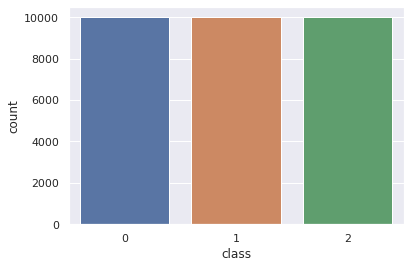

In [81]:
# After balancing data (under-sampling)
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=sampled_dataset)

In [82]:
sampled_dataset.to_csv("data/sampled_dataset.csv")

In [83]:
# create train/validation/test splits
predictor = sampled_dataset.drop("class", axis = "columns")
X_train_val, X_test, y_train_val, y_test = train_test_split(predictor, sampled_dataset["class"], test_size=0.2, random_state=20, stratify = sampled_dataset["class"])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=20, stratify = y_train_val)

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.to_csv("data/train.tsv", sep="\t")
val.to_csv("data/validation.tsv", sep="\t")
test.to_csv("data/test.tsv", sep="\t")